### 8.3. Run our END to ENd pipeline on test images and give description for each clothing item in each image visually

### 8.4. Calculate Accuracy of clothing item detection by YOLOV8

to calculate the accuracy per item for object detection predictions, we can compare the predicted labels from the YOLO model with the ground truth labels we

 manually annotated. Here's a step-by-step guide on how to calculate the accuracy for each item:


In [30]:
import os
import glob
from collections import defaultdict
from ultralytics import YOLO
from torchvision.ops import nms
import torch

# Function to load ground truth annotations
def load_ground_truth_annotations(annot_dir):
    ground_truth = {}
    for annot_file in glob.glob(os.path.join(annot_dir, "*.txt")):
        image_name = os.path.basename(annot_file).replace('.txt', '.jpg')
        with open(annot_file, 'r') as f:
            labels = [line.strip() for line in f.readlines()]
            ground_truth[image_name] = labels
    return ground_truth

# NMS and conflict resolution functions
def apply_nms_and_conflict_resolution(detected_items, iou_threshold=0.5):
    boxes = [item['coordinates'] for item in detected_items]
    scores = [item['confidence'] for item in detected_items]
    labels = [item['label'] for item in detected_items]

    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    scores_tensor = torch.tensor(scores, dtype=torch.float32)

    # Apply NMS
    nms_indices = nms(boxes_tensor, scores_tensor, iou_threshold)

    # Filter boxes, scores, and labels based on NMS output
    nms_boxes = boxes_tensor[nms_indices].tolist()
    nms_scores = scores_tensor[nms_indices].tolist()
    nms_labels = [labels[i] for i in nms_indices]

    # Reformat the filtered results into the detected_items structure
    nms_items = []
    for i in range(len(nms_boxes)):
        nms_items.append({
            'label': nms_labels[i],
            'coordinates': nms_boxes[i],
            'confidence': nms_scores[i]
        })

    return nms_items

def conflict_resolution(items):
    final_items = []
    items_dict = {}
    for i, item in enumerate(items):
        if item['label']:  # Ensure label is not empty
            items_dict[item['label']] = {'confidence': item['confidence'], 'idx': i}

    conflicts = {
        'shirt': ['dress'],
        'pants': ['shorts', 'skirt'],
        'shorts': ['pants', 'skirt'],
        'skirt': ['pants', 'shorts'],
        'dress': ['shirt']
    }

    conflict_pairs = []
    for k in items_dict.keys():
        if k not in conflicts:
            final_items.append(items[items_dict[k]['idx']])
        else:
            flag = True
            for conflict in conflicts[k]:
                if conflict in items_dict.keys():
                    if set([k, conflict]) not in conflict_pairs:
                        conflict_pairs.append(set([k, conflict]))
                    flag = False
            if flag:
                final_items.append(items[items_dict[k]['idx']])

    for i, pair in enumerate(conflict_pairs):
        conflict_pairs[i] = list(pair)
    winners = []

    for pair in conflict_pairs:
        if pair[0] in winners:
            final_items.append(items[items_dict[pair[0]]['idx']])
        elif pair[1] in winners:
            final_items.append(items[items_dict[pair[1]]['idx']])
        elif items_dict[pair[0]]['confidence'] > items_dict[pair[1]]['confidence']:
            final_items.append(items[items_dict[pair[0]]['idx']])
            winners.append(pair[0])
        else:
            final_items.append(items[items_dict[pair[1]]['idx']])
            winners.append(pair[1])
    return final_items

# Main code to calculate accuracy with NMS and conflict resolution applied
def calculate_accuracy_with_nms_and_conflict_resolution():
    base_path = "./"
    base_path_new = "/home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering"
    test_path = os.path.join(base_path_new, "new_images_for_test")
    image_dir = os.path.join(test_path, "images")

    # Load the trained YOLO model
    runs_path = os.path.join(base_path, 'runs', 'detect')
    weights_save_path = os.path.join(runs_path, 'train', 'weights')
    yolo_best_weights_path = os.path.join(weights_save_path, "best.pt")
    model = YOLO(yolo_best_weights_path)

    # Directory containing ground truth annotations
    annot_dir = os.path.join(base_path_new, "ground_truth_dir")

    # Load ground truth annotations
    ground_truth_annotations = load_ground_truth_annotations(annot_dir)

    # Get all images in the directory
    image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))

    # Initialize variables to calculate accuracy
    item_accuracy = defaultdict(lambda: {'correct': 0, 'total': 0})
    image_correct_count = 0
    total_correct_items = 0
    total_items = 0

    # Loop through each image in the test set
    for img_path in image_paths:
        img_name = os.path.basename(img_path)
        ground_truth_labels = ground_truth_annotations.get(img_name, [])
        ground_truth_labels_set = set(ground_truth_labels)

        results = model(img_path)
        detected_items = []
        for result in results:
            boxes = result.boxes
            for box in boxes:
                class_id = int(box.cls[0])
                label = model.names[class_id]
                if label:  # Ensure the label is not empty
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    detected_items.append({
                        'label': label,
                        'coordinates': (x1, y1, x2, y2),
                        'confidence': box.conf[0].item()
                    })

        # Apply NMS and conflict resolution
        nms_items = apply_nms_and_conflict_resolution(detected_items)
        final_items = conflict_resolution(nms_items)

        # Convert final_items to a set for comparison
        predicted_labels_set = set([item['label'] for item in final_items if item['label']])  # Ensure no empty labels

        # Calculate per-item accuracy
        for label in ground_truth_labels_set:
            if label:  # Ensure ground truth label is not empty
                item_accuracy[label]['total'] += 1
                total_items += 1
                if label in predicted_labels_set:
                    item_accuracy[label]['correct'] += 1
                    total_correct_items += 1

        # Calculate per-image accuracy
        correct_items = len(predicted_labels_set & ground_truth_labels_set)
        image_accuracy = correct_items / len(ground_truth_labels_set) if ground_truth_labels_set else 0
        if image_accuracy == 1.0:
            image_correct_count += 1

    

    # Calculate and print image accuracy
    total_images = len(image_paths)
    image_accuracy_percent = image_correct_count / total_images * 100
    print(f"Accuracy per image: {image_accuracy_percent:.2f}%")

    # Calculate and print total accuracy per clothing item
    total_item_accuracy = total_correct_items / total_items * 100 if total_items > 0 else 0
    print(f"Total Accuracy per clothing item: {total_item_accuracy:.2f}%")

# Run the accuracy calculation with NMS and conflict resolution applied
calculate_accuracy_with_nms_and_conflict_resolution()


image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/new_images_for_test/images/007169.jpg: 448x640 1 skirt, 1 dress, 1 shoe, 35.1ms
Speed: 1.8ms preprocess, 35.1ms inference, 87.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/new_images_for_test/images/007292.jpg: 640x416 1 sunglass, 1 shirt, 1 skirt, 1 bag, 1 shoe, 31.1ms
Speed: 1.6ms preprocess, 31.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)

image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/new_images_for_test/images/070080.jpg: 640x448 1 shirt, 1 pants, 1 shoe, 30.8ms
Speed: 1.9ms preprocess, 30.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/new_images_for_test/images/024438.jpg: 640x448 1 shirt, 1 shorts, 1 bag, 1 shoe, 18.1ms
Speed: 2.1ms preprocess, 18.1ms inference, 1.2ms postproc

#### 8.5. Graph for Accuracy

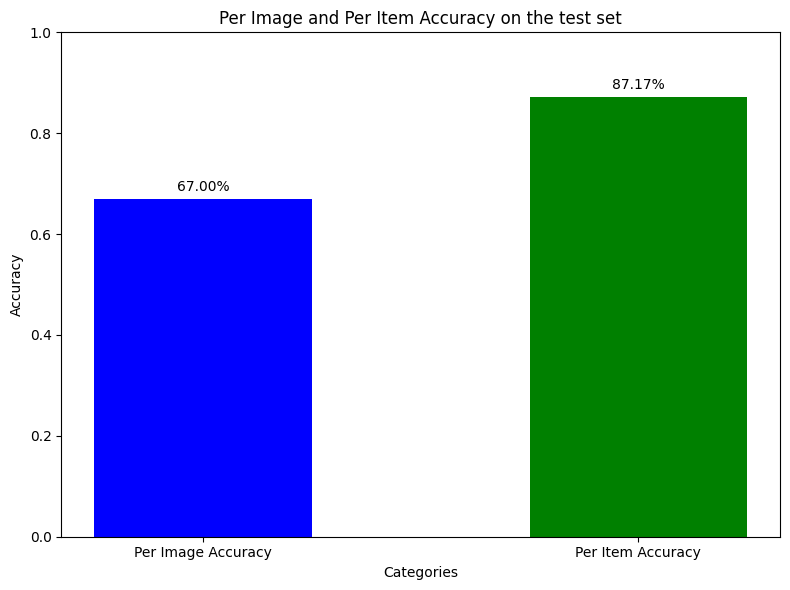

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Define accuracy data
categories = ['Per Image Accuracy', 'Per Item Accuracy']
accuracy_values = [0.67, 0.8717]  # Corresponding accuracy values

# Define bar width and positions
bar_width = 0.5
index = np.arange(len(categories))

# Create the bar plot
plt.figure(figsize=(8, 6))

# Plot the bars
bars = plt.bar(index, accuracy_values, bar_width, color=['blue', 'green'])

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Accuracy')
plt.title('Per Image and Per Item Accuracy on the test set')
plt.xticks(index, categories)
plt.ylim(0, 1)  # Set y-axis limit from 0 to 1

# Add text labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.2%}', ha='center', va='bottom')

# Display the plot
plt.tight_layout()
plt.show()

from the bar plot, per item accuracy is 87.17% and per image 67%. these values align well with the results observed in our own dataset, demonstrating the 

robustness of the model across different sets of data. This consistency validates the model's effectiveness in accurately identifying and classifying clothing 

items, even with varied test conditions.

### 8.6. Calculate Percision and recall and draw AUC-PR Graph


image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/new_images_for_test/images/007169.jpg: 448x640 1 skirt, 1 dress, 1 shoe, 19.2ms
Speed: 1.6ms preprocess, 19.2ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/new_images_for_test/images/007292.jpg: 640x416 1 sunglass, 1 shirt, 1 skirt, 1 bag, 1 shoe, 18.1ms
Speed: 1.8ms preprocess, 18.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 416)

image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/new_images_for_test/images/070080.jpg: 640x448 1 shirt, 1 pants, 1 shoe, 19.1ms
Speed: 1.5ms preprocess, 19.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

image 1/1 /home/zohreh/Documents/color_detection_YOLO_SAM_KMeansClustering/new_images_for_test/images/024438.jpg: 640x448 1 shirt, 1 shorts, 1 bag, 1 shoe, 17.5ms
Speed: 1.7ms preprocess, 17.5ms inference, 1.1ms postproce

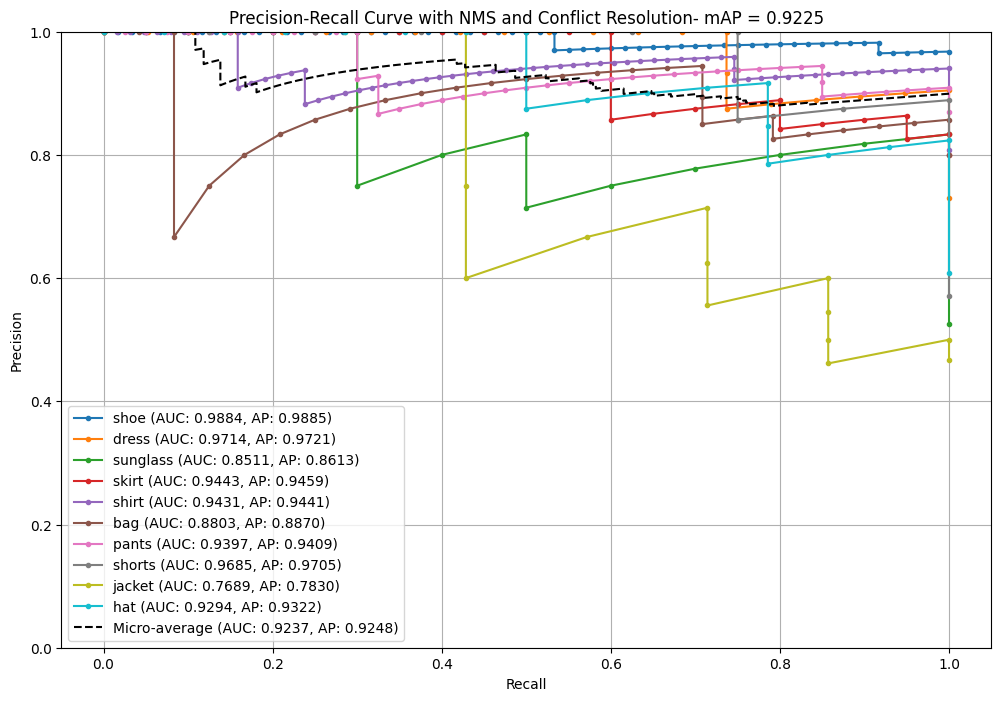

In [15]:
import os
import glob
from collections import defaultdict
from ultralytics import YOLO
from torchvision.ops import nms
import torch
import numpy as np
from sklearn.metrics import precision_recall_curve, auc, average_precision_score
import matplotlib.pyplot as plt

# Function to load ground truth annotations
def load_ground_truth_annotations(annot_dir):
    ground_truth = {}
    for annot_file in glob.glob(os.path.join(annot_dir, "*.txt")):
        image_name = os.path.basename(annot_file).replace('.txt', '.jpg')
        with open(annot_file, 'r') as f:
            labels = [line.strip() for line in f.readlines()]
            ground_truth[image_name] = labels
    return ground_truth

# NMS and conflict resolution functions
def apply_nms_and_conflict_resolution(detected_items, iou_threshold=0.5):
    boxes = [item['coordinates'] for item in detected_items]
    scores = [item['confidence'] for item in detected_items]
    labels = [item['label'] for item in detected_items]

    boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
    scores_tensor = torch.tensor(scores, dtype=torch.float32)

    # Apply NMS
    nms_indices = nms(boxes_tensor, scores_tensor, iou_threshold)

    # Filter boxes, scores, and labels based on NMS output
    nms_boxes = boxes_tensor[nms_indices].tolist()
    nms_scores = scores_tensor[nms_indices].tolist()
    nms_labels = [labels[i] for i in nms_indices]

    # Reformat the filtered results into the detected_items structure
    nms_items = []
    for i in range(len(nms_boxes)):
        nms_items.append({
            'label': nms_labels[i],
            'coordinates': nms_boxes[i],
            'confidence': nms_scores[i]
        })

    return nms_items

def conflict_resolution(items):
    final_items = []
    items_dict = {}
    for i, item in enumerate(items):
        if item['label']:  # Ensure label is not empty
            items_dict[item['label']] = {'confidence': item['confidence'], 'idx': i}

    conflicts = {
        'shirt': ['dress'],
        'pants': ['shorts', 'skirt'],
        'shorts': ['pants', 'skirt'],
        'skirt': ['pants', 'shorts'],
        'dress': ['shirt']
    }

    conflict_pairs = []
    for k in items_dict.keys():
        if k not in conflicts:
            final_items.append(items[items_dict[k]['idx']])
        else:
            flag = True
            for conflict in conflicts[k]:
                if conflict in items_dict.keys():
                    if set([k, conflict]) not in conflict_pairs:
                        conflict_pairs.append(set([k, conflict]))
                    flag = False
            if flag:
                final_items.append(items[items_dict[k]['idx']])

    for i, pair in enumerate(conflict_pairs):
        conflict_pairs[i] = list(pair)
    winners = []

    for pair in conflict_pairs:
        if pair[0] in winners:
            final_items.append(items[items_dict[pair[0]]['idx']])
        elif pair[1] in winners:
            final_items.append(items[items_dict[pair[1]]['idx']])
        elif items_dict[pair[0]]['confidence'] > items_dict[pair[1]]['confidence']:
            final_items.append(items[items_dict[pair[0]]['idx']])
            winners.append(pair[0])
        else:
            final_items.append(items[items_dict[pair[1]]['idx']])
            winners.append(pair[1])
    return final_items

# Main code to calculate accuracy and Precision-Recall with NMS and conflict resolution applied
def calculate_pr_curve_with_nms_and_conflict_resolution():
    base_path = "./"
    test_path = os.path.join(base_path_new, "new_images_for_test")
    image_dir = os.path.join(test_path, "images")

    # Load the trained YOLO model
    runs_path = os.path.join(base_path, 'runs', 'detect')
    weights_save_path = os.path.join(runs_path, 'train', 'weights')
    yolo_best_weights_path = os.path.join(weights_save_path, "best.pt")
    model = YOLO(yolo_best_weights_path)

    # Directory containing ground truth annotations
    annot_dir = os.path.join(base_path_new, "ground_truth_dir")

    # Load ground truth annotations
    ground_truth_annotations = load_ground_truth_annotations(annot_dir)

    # Get all images in the directory
    image_paths = glob.glob(os.path.join(image_dir, "*.jpg"))

    # Initialize variables to collect predictions and ground truth for AUC-PR calculation
    all_labels = defaultdict(list)
    all_scores = defaultdict(list)
    all_ground_truths = defaultdict(list)

    # Initialize for micro-averaging
    micro_all_scores = []
    micro_all_ground_truths = []

    # Loop through each image in the test set
    for img_path in image_paths:
        img_name = os.path.basename(img_path)
        ground_truth_labels = ground_truth_annotations.get(img_name, [])
        ground_truth_labels_set = set(ground_truth_labels)

        results = model(img_path)
        detected_items = []
        for result in results:
            boxes = result.boxes
            for box in boxes:
                class_id = int(box.cls[0])
                label = model.names[class_id]
                if label:  # Ensure the label is not empty
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    detected_items.append({
                        'label': label,
                        'coordinates': (x1, y1, x2, y2),
                        'confidence': box.conf[0].item()
                    })

        # Apply NMS and conflict resolution
        nms_items = apply_nms_and_conflict_resolution(detected_items)
        final_items = conflict_resolution(nms_items)

        # Collect ground truth and prediction data per class
        for label in ground_truth_labels_set:
            if label:  # Ensure ground truth label is not empty
                all_ground_truths[label].append(1 if label in [item['label'] for item in final_items] else 0)
                all_scores[label].append(max([item['confidence'] for item in final_items if item['label'] == label], default=0))
                all_labels[label].append(label)

                # Append for micro-average
                micro_all_ground_truths.append(1)
                micro_all_scores.append(all_scores[label][-1])

        # Handle predictions that don't exist in the ground truth for the current image
        predicted_labels_set = set(item['label'] for item in final_items)
        for label in predicted_labels_set - ground_truth_labels_set:
            all_ground_truths[label].append(0)
            for item in final_items:
                if item['label'] == label:
                    all_scores[label].append(item['confidence'])
                    all_labels[label].append(label)

                    # Append for micro-average
                    micro_all_ground_truths.append(0)
                    micro_all_scores.append(all_scores[label][-1])

    # Calculate and plot Precision-Recall curve for each class
    plt.figure(figsize=(12, 8))
    ap_values = []
    for label in all_labels.keys():
        precision, recall, _ = precision_recall_curve(all_ground_truths[label], all_scores[label])
        ap = average_precision_score(all_ground_truths[label], all_scores[label])
        auc_pr = auc(recall, precision)
        ap_values.append(ap)
        plt.plot(recall, precision, marker='.', label=f'{label} (AUC: {auc_pr:.4f}, AP: {ap:.4f})')

    # Plot Micro-average Precision-Recall curve
    micro_precision, micro_recall, _ = precision_recall_curve(micro_all_ground_truths, micro_all_scores)
    micro_auc_pr = auc(micro_recall, micro_precision)
    micro_ap = average_precision_score(micro_all_ground_truths, micro_all_scores)
    plt.plot(micro_recall, micro_precision, color='black', linestyle='--', label=f'Micro-average (AUC: {micro_auc_pr:.4f}, AP: {micro_ap:.4f})')
    
    # Calculate mAP
    mean_ap = sum(ap_values) / len(ap_values)
    print(f"Mean Average Precision (mAP): {mean_ap:.4f}")
    print(f"Micro-average AP: {micro_ap:.4f}")

    # Plot settings
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve with NMS and Conflict Resolution- mAP = {mean_ap:.4f}')
    plt.legend()
    plt.grid()
    plt.ylim([0, 1])
    plt.show()

    

# Run the Precision-Recall curve calculation with NMS and conflict resolution applied
calculate_pr_curve_with_nms_and_conflict_resolution()

with precision recall curve and values for AP and AUC-PR, we see consistency between the result from new images and our dataset result

### Calculating the Accuracy of dominant color of clothing items

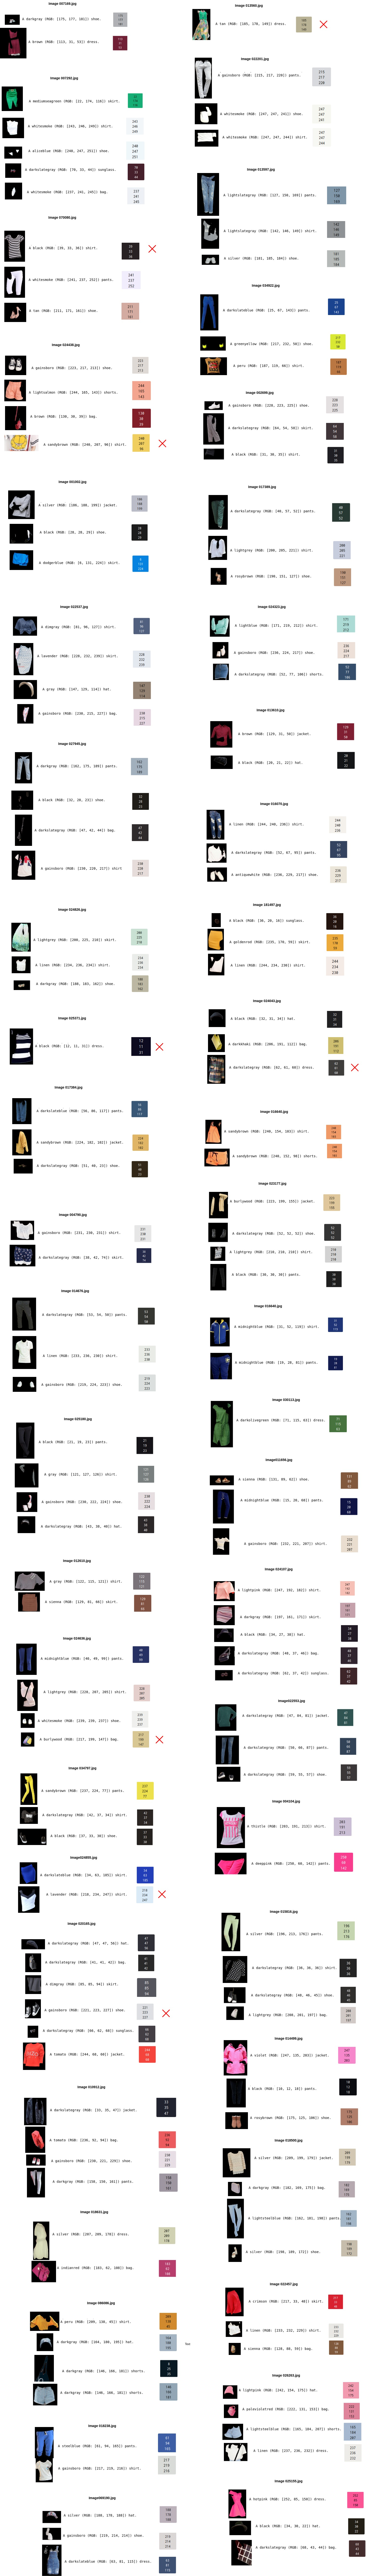

In [12]:
import os
from IPython.display import Image, display

# Path to your image
img_path = '/home/zohreh/Pictures/Screenshots/Color_detection_test.jpg'
# Check if the file exists
if os.path.exists(img_path):
    display(Image(filename=img_path))
else:
    print(f"File not found: {img_path}")


### Accuracy of color predicte4d by our pipeline architecture

In [2]:
# manual RGB verification
number_of_correct_predictions = 42
total_number_of_images = 50
Accuracy = number_of_correct_predictions / total_number_of_images
print(f'Accuracy of predicted dominant color from pipeline:{Accuracy}') 

Accuracy of predicted dominant color from pipeline:0.84


Although our model achieved a dominant color prediction accuracy of 84%, it still struggled in scenarios involving multi-colored items or when segmentation was not

 accurate. These challenges affected some predictions, but overall, the results remain consistent when compared to our own dataset, indicating stable performance
 
  across similar issues.The result of accuracy demonstrates the robustness of our pipeline, highlighting its ability to deliver consistent and reliable 
  
  color predictions despite the challenges associated with multi-colored items and occasional segmentation inaccuracies.